In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
from pathlib import Path
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import cv2
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
sdir = './data'

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
df=pd.read_csv('./blocks-labels.csv')
df['stable']=df['stable'].astype(str)
df['id']=df['id'].astype(str)
df['id']=df['id'].apply(lambda x: x+'.jpg')
print (df.head())
file_count=5000  # set how many samples of each class to use
if file_count != 'all':
        samples = []
        for category in df['stable'].unique():    
            category_slice = df.query("stable == @category")    
            samples.append(category_slice.sample(file_count, random_state=1))
        df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True) 
sample_count= df['stable'].value_counts()
print (sample_count)

      id stable
0  1.jpg      1
1  2.jpg      1
2  3.jpg      1
3  4.jpg      0
4  5.jpg      0
1    5000
0    5000
Name: stable, dtype: int64


In [5]:
img_path=r'./data/1.jpg'
img=cv2.imread(img_path)
img_shape=img.shape
print ('shape of image is: ', img_shape)

shape of image is:  (400, 640, 3)


In [6]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print('train df size: ' , len(train_df),'  test df size: ', len(test_df), ' valid size: ', len (valid_df))

train df size:  8000   test df size:  1000  valid size:  1000


In [7]:
batch_size=80
length= len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]  
test_steps=int(length/test_batch_size) 
print (' test batch size: ', test_batch_size, '  test steps:', test_steps)

 test batch size:  50   test steps: 20


In [8]:
print(train_df["id"])

9216     7821.jpg
7324    20022.jpg
918     24709.jpg
5902     9860.jpg
2807    25880.jpg
          ...    
9785    32575.jpg
7763    13298.jpg
5218     8222.jpg
1346    42571.jpg
3582    48958.jpg
Name: id, Length: 8000, dtype: object


In [9]:
def scalar(x):
    return x/127.5 - 1

gen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=gen.flow_from_dataframe(train_df, sdir, x_col='id', y_col='stable', target_size= (224,224), class_mode ='sparse', batch_size=batch_size,
                                  shuffle=True, seed = 123)
valid_gen=gen.flow_from_dataframe(valid_df, sdir, x_col='id', y_col='stable', target_size= (224,224), class_mode= 'sparse', batch_size=batch_size,
                                  shuffle=True, seed = 123)
test_gen=gen.flow_from_dataframe(test_df, sdir, x_col='id', y_col='stable', target_size= (224,224), class_mode ='sparse', batch_size=test_batch_size,
                                  shuffle=False)

Found 8000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [10]:
def show_image_samples(gen):
    class_dict=gen.class_indices
    new_dict={}
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}
        new_dict[value]=key        
    images,labels=next(gen) # get a sample batch from the generator   
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=new_dict[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

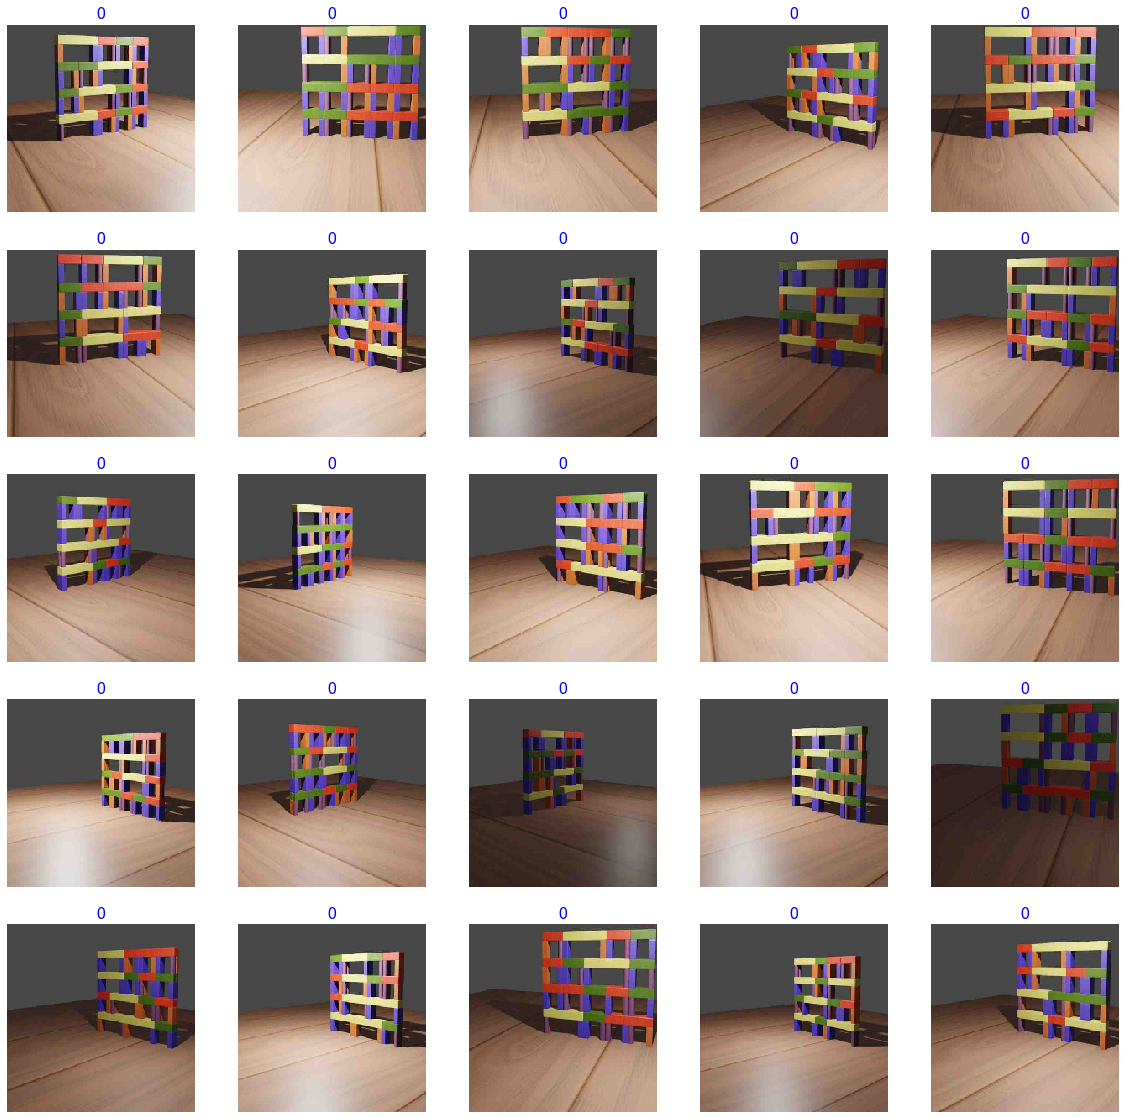

In [11]:
show_image_samples(train_gen)

In [12]:
freeze=True # freeze the base model weights at the imagenet weights

height=224
width=224
img_shape=(height, width, 3)
dropout=.3
lr=.001
img_shape=(height, width, 3)
base_model=tf.keras.applications.MobileNetV2( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet') 
if freeze:
    base_model.trainable== False
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform(seed=123))(x)
x=Dropout(rate=dropout, seed=123)(x)        
output=Dense(1, activation='sigmoid',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=123))(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=lr), loss='binary_crossentropy', metrics=['accuracy']) 

C:\Users\Gautam\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
def print_in_color(txt_msg,fore_tupple= (255,255,0),back_tupple=(55,65,80)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [14]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,end_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        self.count=0 # initialize counter that counts epochs with no improvement
        self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.end_epoch=end_epoch # value of the number of epochs to run
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
            
    def on_epoch_begin(self, epoch, logs=None): # just used to print data from previous epoch
        if epoch != 0:
            msgs=f'for epoch {epoch} '
            msgs=msgs + LRA.msg
            print_in_color(msgs, (255,255,0), (55,65,80))
            
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            if acc>self.highest_tracc: # training accuracy improved in the epoch
                LRA.msg= f' training accuracy improved from  {self.highest_tracc:7.4f} to {acc:7.4f} learning rate held at {lr:10.8f}'
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss             
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss
                    msgs=f' training accuracy {acc:7.4f} < highest accuracy of {self.highest_tracc:7.4f} '
                    LRA.msg=msgs + f' for {self.patience } epochs, lr adjusted to {self.lr:10.8f}'                    
                else:
                    self.count=self.count +1 # increment patience counter
                    LRA.msg=f' training accuracy {acc:7.4f} < highest accuracy of {self.highest_tracc:7.4f} '
                    #print_in_color(msg, (255,255,0), (55,65,80))
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            if v_loss< self.lowest_vloss: # check if the validation loss improved
                msgs=f' validation loss improved from {self.lowest_vloss:8.5f} to {v_loss:8.5}, saving best weights'
                LRA.msg=msgs + f' learning rate held at {self.lr:10.8f}'
                #print_in_color(msg, (0,255,0), (55,65,80))
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0                    
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    self.lr=self.lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted                    
                    msgs=f' val_loss of {v_loss:8.5f} > {self.lowest_vloss:8.5f} for {self.patience} epochs'
                    LRA.msg=msgs + f', lr adjusted to {self.lr:10.8f}'
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter
                    LRA.msg=f' validation loss of {v_loss:8.5f} > {self.lowest_vloss:8.5f}'
                    #print_in_color(msg, (255,255,0), (55,65,80)) 
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        if epoch==self.end_epoch:
            print_in_color(LRA.msg, (255,255,0), (55,65,80)) # print out data for the final epoch
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            LRA.msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(LRA.msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

In [15]:
patience=1
stop_patience=5
threshold=.9
factor=.5
dwell=True
model_type='MobilenetV2'

epochs=10

callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_type, freeze=freeze, end_epoch=epochs - 1 )]

 Starting training using  base model MobilenetV2 with weights frozen to imagenet weights initializing LRA callback



In [ ]:
history=model.fit(train_gen, epochs=epochs, validation_data= valid_gen, callbacks=callbacks, verbose=2)

Epoch 1/10


In [28]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15402184826294527307
]


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

''